New code

In [ ]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Function to read and preprocess images from a directory
def read_images_from_directory(directory_path):
    images = []
    for filename in os.listdir(directory_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(directory_path, filename)
            image = Image.open(image_path).convert('L')  # Convert to grayscale
            images.append(np.array(image))
    return images

# Function to extract patches and compute feature vectors
def extract_patches(image, patch_size=7, stride=1):
    height, width = image.shape
    num_patches_x = (width - patch_size) // stride + 1
    num_patches_y = (height - patch_size) // stride + 1
    num_patches = num_patches_x * num_patches_y
    features = np.zeros((num_patches, 2))  # Pre-allocate memory for features

    idx = 0
    for i in range(0, height - patch_size + 1, stride):
        for j in range(0, width - patch_size + 1, stride):
            patch = image[i:i + patch_size, j:j + patch_size]
            features[idx, 0] = np.mean(patch)
            features[idx, 1] = np.std(patch)
            idx += 1
    return features

# Function to extract features from all images
def extract_features_from_images(images, patch_size=7, stride=1):
    all_features = []
    for image in images:
        patches = extract_patches(image, patch_size, stride)
        all_features.append(patches)
    return np.vstack(all_features)  # Stack all features together

# Example usage
directory_path = 'Cancer Dataset\\Train'
print("started reading images")
images = read_images_from_directory(directory_path)
print("finished reading images")
print(len(images))
# Extract features from all images
all_patch_features = extract_features_from_images(images, patch_size=7, stride=1)
print(len(all_patch_features))


started reading images
finished reading images
60
15362160


In [6]:

def kmeans_clustering(data, k, centroids):
    
    while True:
        # Calculate distance matrix between data points and centroids
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        
        # Update centroids based on new clusters
        new_centroids = np.array([data[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i]
                                  for i in range(k)])
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    return labels, centroids


In [7]:

def modified_kmeans_clustering(data, k, centroids):
    
    cov_matrix = np.cov(data.T)
    cov_inv = np.linalg.inv(cov_matrix)
    
    while True:
        # Calculate Mahalanobis distance matrix between data points and centroids
        distances = np.array([np.sqrt(np.einsum('ij,jk,ik->i', data - centroid, cov_inv, data - centroid)) 
                              for centroid in centroids]).T
        labels = np.argmin(distances, axis=1)
        
        # Update centroids based on new clusters
        new_centroids = np.array([data[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i]
                                  for i in range(k)])
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    return labels, centroids


In [13]:
def map_clusters_to_images(images, labels, patch_size=7, stride=1):
    segmented_images = []
    idx = 0  # Index to track the label assignments
    
    for image in images:
        height, width = image.shape
        segmented_image = np.zeros((height, width))  # Create an empty image for cluster labels
        num_patches_x = (width - patch_size) // stride + 1
        num_patches_y = (height - patch_size) // stride + 1
        for i in range(0, height - patch_size + 1, stride):
            for j in range(0, width - patch_size + 1, stride):
                # Assign the cluster label to the corresponding patch in the image
                segmented_image[i:i + patch_size, j:j + patch_size] = labels[idx]
                idx += 1
        segmented_images.append(segmented_image)
    return segmented_images

k = 3  # Number of clusters (3 for cell segmentation)
centroids = all_patch_features[np.random.choice(all_patch_features.shape[0], k, replace=False)]
clusters_kmeans, centroids_kmeans = kmeans_clustering(all_patch_features, k, centroids)
# Map clusters to the original images (for K-means)
segmented_images_kmeans = map_clusters_to_images(images, clusters_kmeans)
clusters_mahalanobis, centroids_mahalanobis = modified_kmeans_clustering(all_patch_features, k, centroids)



In [14]:

# Function to assign test patches to the nearest clusters (K-means)
def assign_clusters_to_test_data(test_features, centroids):
    distances = np.linalg.norm(test_features[:, np.newaxis] - centroids, axis=2)
    labels = np.argmin(distances, axis=1)
    return labels

# Function to assign test patches to the nearest clusters (Mahalanobis-based K-means)
def assign_mahalanobis_clusters_to_test_data(test_features, centroids, cov_matrix):
    cov_inv = np.linalg.inv(cov_matrix)
    distances = np.array([np.sqrt(np.einsum('ij,jk,ik->i', test_features - centroid, cov_inv, test_features - centroid)) 
                          for centroid in centroids]).T
    labels = np.argmin(distances, axis=1)
    return labels

# Directory for test images
test_directory_path = 'D:\\IIT DH\\1st sem\\Statistical Pattern Recognition\\Assignment2\\group11\\group11\\Test'
print("Started reading test images")
test_images = read_images_from_directory(test_directory_path)
print("Finished reading test images")
print(f"Number of test images: {len(test_images)}")

# Extract features from test images
test_patch_features = extract_features_from_images(test_images, patch_size=7, stride=1)
print(f"Number of test patches: {len(test_patch_features)}")

# Testing using K-means clusters
clusters_kmeans_test = assign_clusters_to_test_data(test_patch_features, centroids_kmeans)

# Testing using Mahalanobis-based K-means clusters
clusters_mahalanobis_test = assign_mahalanobis_clusters_to_test_data(test_patch_features, centroids_mahalanobis, np.cov(all_patch_features.T))

# Map the predicted clusters back to the test images
segmented_images_kmeans_test = map_clusters_to_images(test_images, clusters_kmeans_test)
segmented_images_mahalanobis_test = map_clusters_to_images(test_images, clusters_mahalanobis_test)



Started reading test images
Finished reading test images
Number of test images: 3
Number of test patches: 768108


In [8]:
def plot_clusters(data, centroids, clusters,title):
    if len(data) != len(clusters):
        print(f"Error: Data size ({len(data)}) and clusters size ({len(clusters)}) do not match.")
        return

    plt.figure(figsize=(8, 6))
    
    k = len(centroids)
    colors = [
    'r', 'g', 'b', 'y', 'c', 'm',
    'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgreen', 'darkkhaki', 
    'darkmagenta', 'darkolivegreen', 'darkorange', 'darkorchid', 'darkred', 
    'darksalmon', 'darkseagreen', 'darkslateblue', 'darkslategray', 'darkturquoise', 
    'darkviolet', 'dimgray', 'midnightblue', 'black', 'brown', 'maroon', 
    'sienna', 'darkblue', 'navy', 'midnightblue', 'indigo', 'purple', 
    'darkviolet', 'darkmagenta', 'darkorchid', 'mediumblue', 'royalblue', 
    'teal', 'darkcyan', 'darkturquoise', 'seagreen', 'forestgreen', 'green', 
    'darkgreen', 'olive', 'olivedrab', 'darkolivegreen', 'khaki', 'goldenrod', 
    'chocolate', 'saddlebrown', 'firebrick', 'darkred', 'crimson', 
    'orangered', 'tomato', 'coral', 'darkorange', 'gold', 
    'sienna', 'brown', 'burlywood', 'indianred'
    ]

    
    for i in range(k):
        cluster_points = data[clusters == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=colors[i], label=f'Cluster {i+1}')
    
    plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='black', marker='x', label='Centroids')
    
    plt.title(f'{title}K-Means Clustering')
    plt.xlabel('Mean')
    plt.ylabel('Variance')
    plt.legend()
    plt.show()

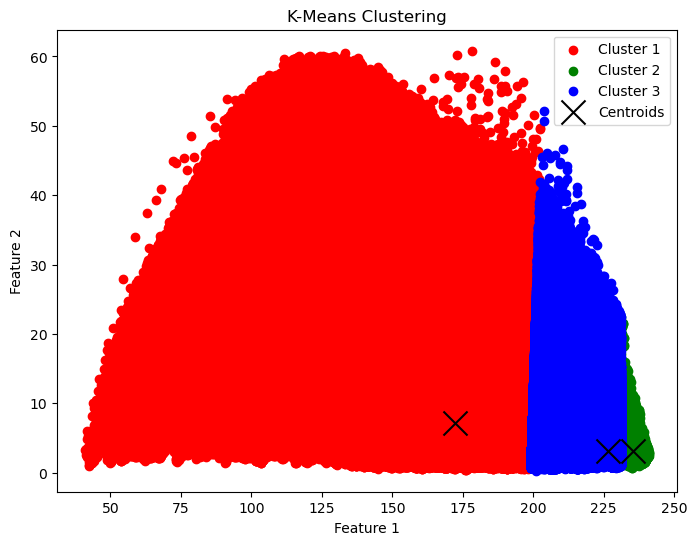

In [9]:
plot_clusters(all_patch_features,centroids_kmeans,clusters_kmeans,'')

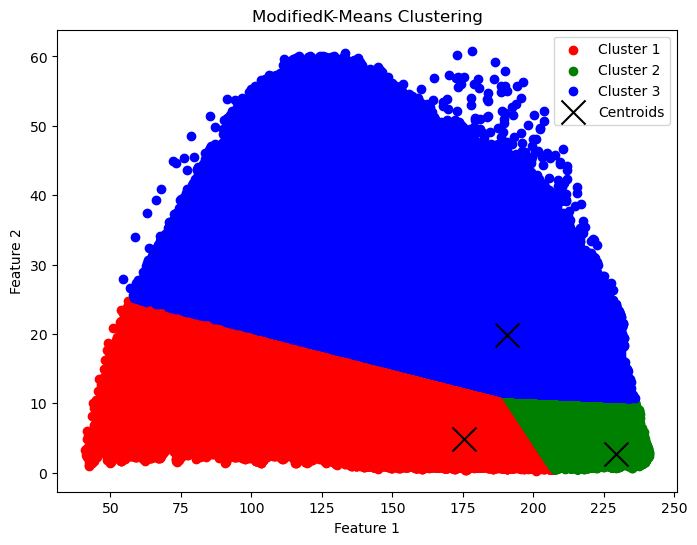

In [10]:
plot_clusters(all_patch_features,centroids_mahalanobis,clusters_mahalanobis,'Modified')

In [ ]:
k = 3  # Number of clusters (3 for cell segmentation)
centroids = all_patch_features[np.random.choice(all_patch_features.shape[0], k, replace=False)]
clusters_kmeans, centroids_kmeans = kmeans_clustering(all_patch_features, k, centroids)
# Map clusters to the original images (for K-means)
segmented_images_kmeans = map_clusters_to_images(images, clusters_kmeans)
clusters_mahalanobis, centroids_mahalanobis = modified_kmeans_clustering(all_patch_features, k, centroids)

# Function to assign test patches to the nearest clusters (K-means)
def assign_clusters_to_test_data(test_features, centroids):
    distances = np.linalg.norm(test_features[:, np.newaxis] - centroids, axis=2)
    labels = np.argmin(distances, axis=1)
    return labels

# Function to assign test patches to the nearest clusters (Mahalanobis-based K-means)
def assign_mahalanobis_clusters_to_test_data(test_features, centroids, cov_matrix):
    cov_inv = np.linalg.inv(cov_matrix)
    distances = np.array([np.sqrt(np.einsum('ij,jk,ik->i', test_features - centroid, cov_inv, test_features - centroid)) 
                          for centroid in centroids]).T
    labels = np.argmin(distances, axis=1)
    return labels

# Directory for test images
test_directory_path = 'Cancer Dataset\\Test'
print("Started reading test images")
test_images = read_images_from_directory(test_directory_path)
print("Finished reading test images")
print(f"Number of test images: {len(test_images)}")

# Extract features from test images
test_patch_features = extract_features_from_images(test_images, patch_size=7, stride=1)
print(f"Number of test patches: {len(test_patch_features)}")

# Testing using K-means clusters
clusters_kmeans_test = assign_clusters_to_test_data(test_patch_features, centroids_kmeans)

# Testing using Mahalanobis-based K-means clusters
clusters_mahalanobis_test = assign_mahalanobis_clusters_to_test_data(test_patch_features, centroids_mahalanobis, np.cov(all_patch_features.T))

# Map the predicted clusters back to the test images
segmented_images_kmeans_test = map_clusters_to_images(test_images, clusters_kmeans_test)
segmented_images_mahalanobis_test = map_clusters_to_images(test_images, clusters_mahalanobis_test)



Started reading test images
Finished reading test images
Number of test images: 3
Number of test patches: 768108


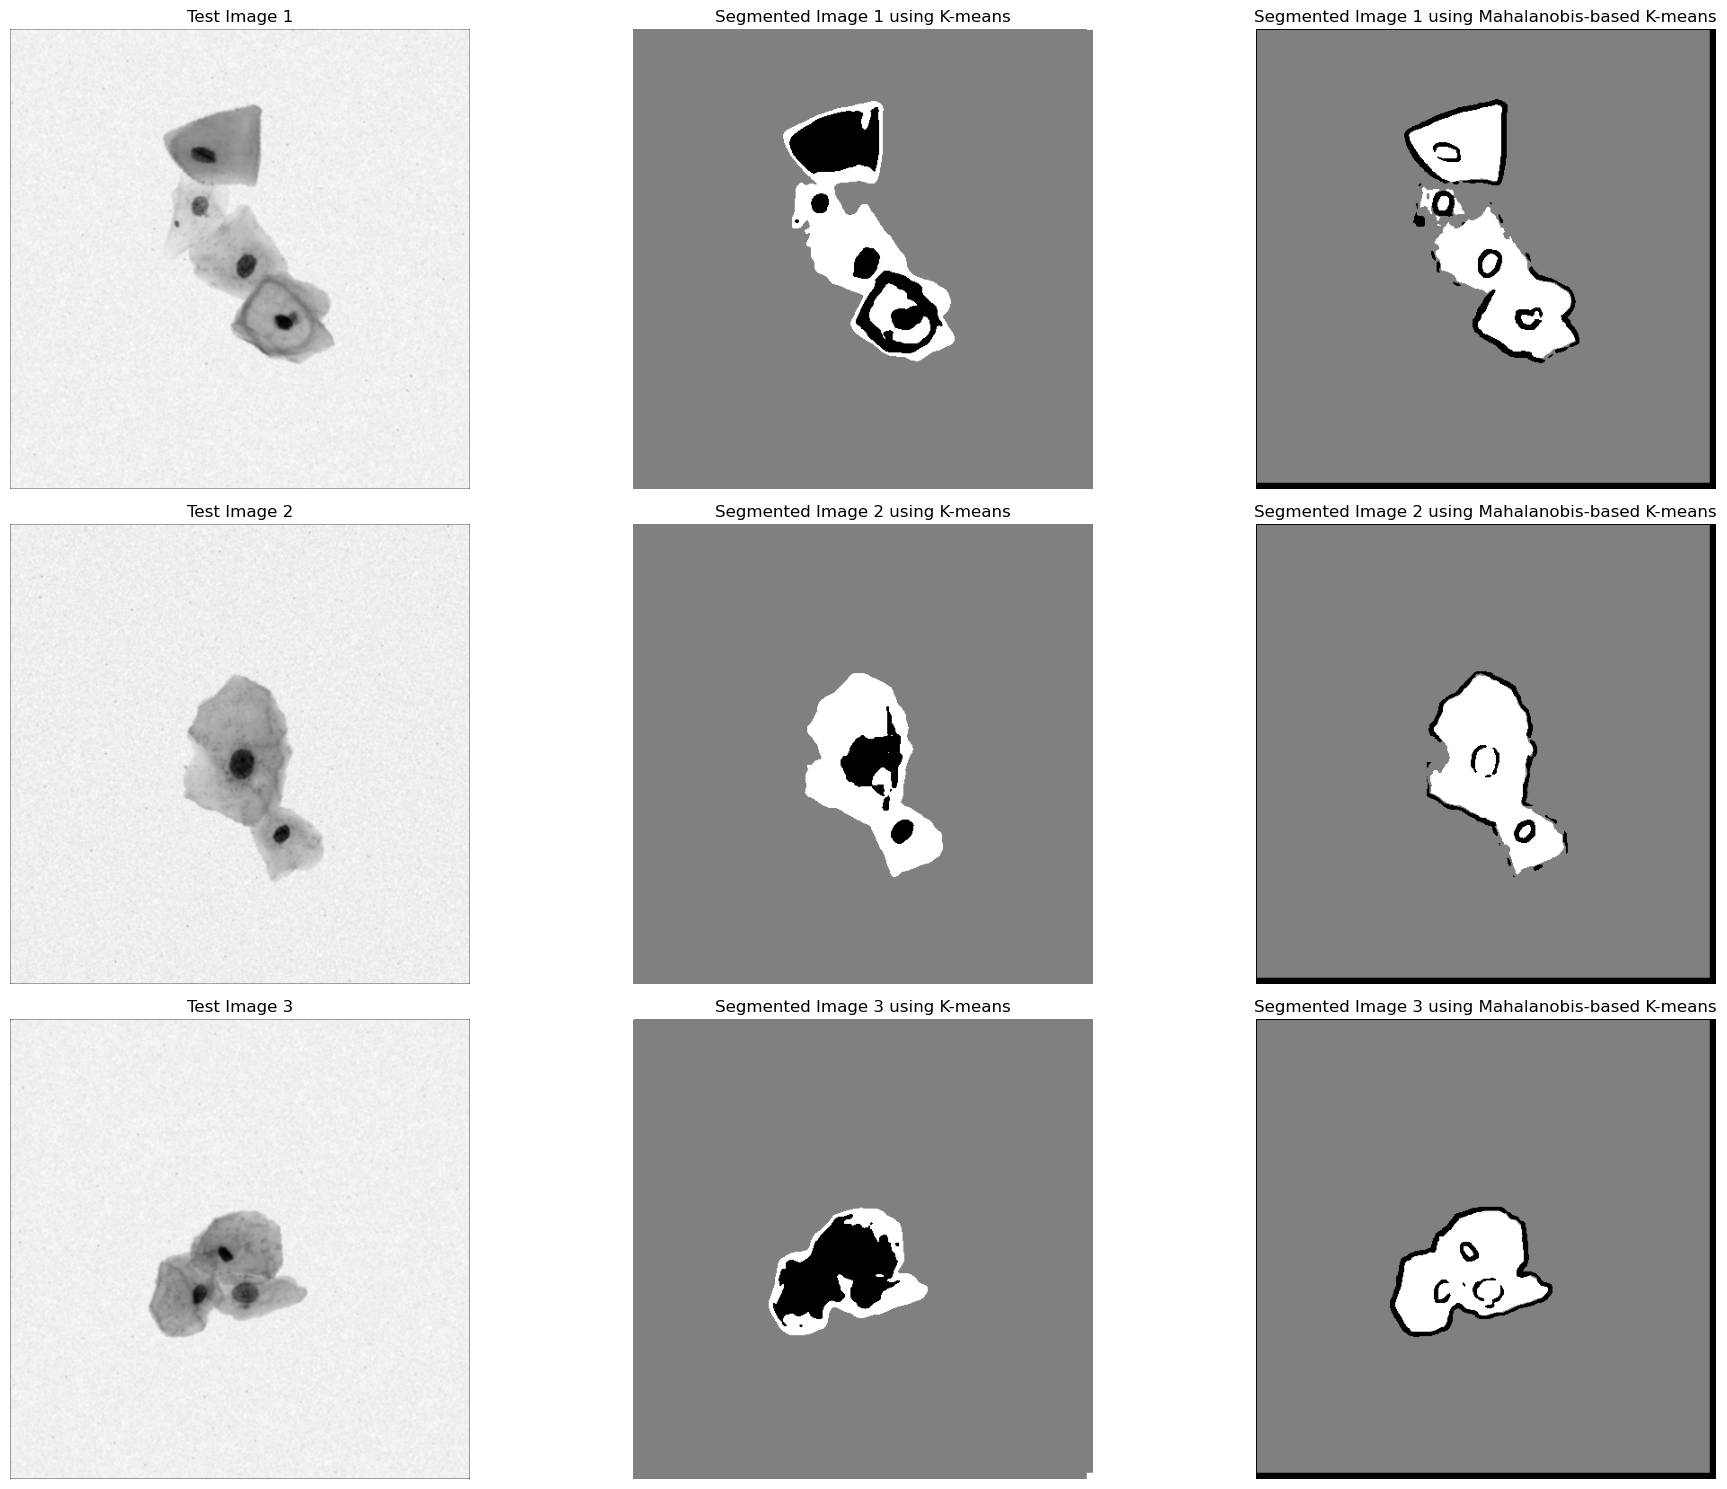

In [15]:
import matplotlib.pyplot as plt

def display_segmented_images_side_by_side(test_images,segmented_images_kmeans, segmented_images_mahalanobis):
    num_images = len(segmented_images_kmeans)
    
    # Create subplots to display K-means and Mahalanobis-based K-means results side by side
    fig, axes = plt.subplots(num_images, 3, figsize=(20, num_images * 5))  # Adjust figure size based on the number of images

    for i, (image,kmeans_image, mahalanobis_image) in enumerate(zip(test_images,segmented_images_kmeans, segmented_images_mahalanobis)):
        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title(f'Test Image {i+1}')
        axes[i, 0].axis('off')  # Remove axis
        # Plot K-means result
        axes[i, 1].imshow(kmeans_image, cmap='gray')
        axes[i, 1].set_title(f'Segmented Image {i+1} using K-means')
        axes[i, 1].axis('off')  # Remove axis
        
        # Plot Mahalanobis-based K-means result
        axes[i, 2].imshow(mahalanobis_image, cmap='gray')
        axes[i, 2].set_title(f'Segmented Image {i+1} using Mahalanobis-based K-means')
        axes[i, 2].axis('off')  # Remove axis
    
    plt.tight_layout()
    plt.show()

# Call the function to display segmented images
display_segmented_images_side_by_side(test_images,segmented_images_kmeans_test, segmented_images_mahalanobis_test)


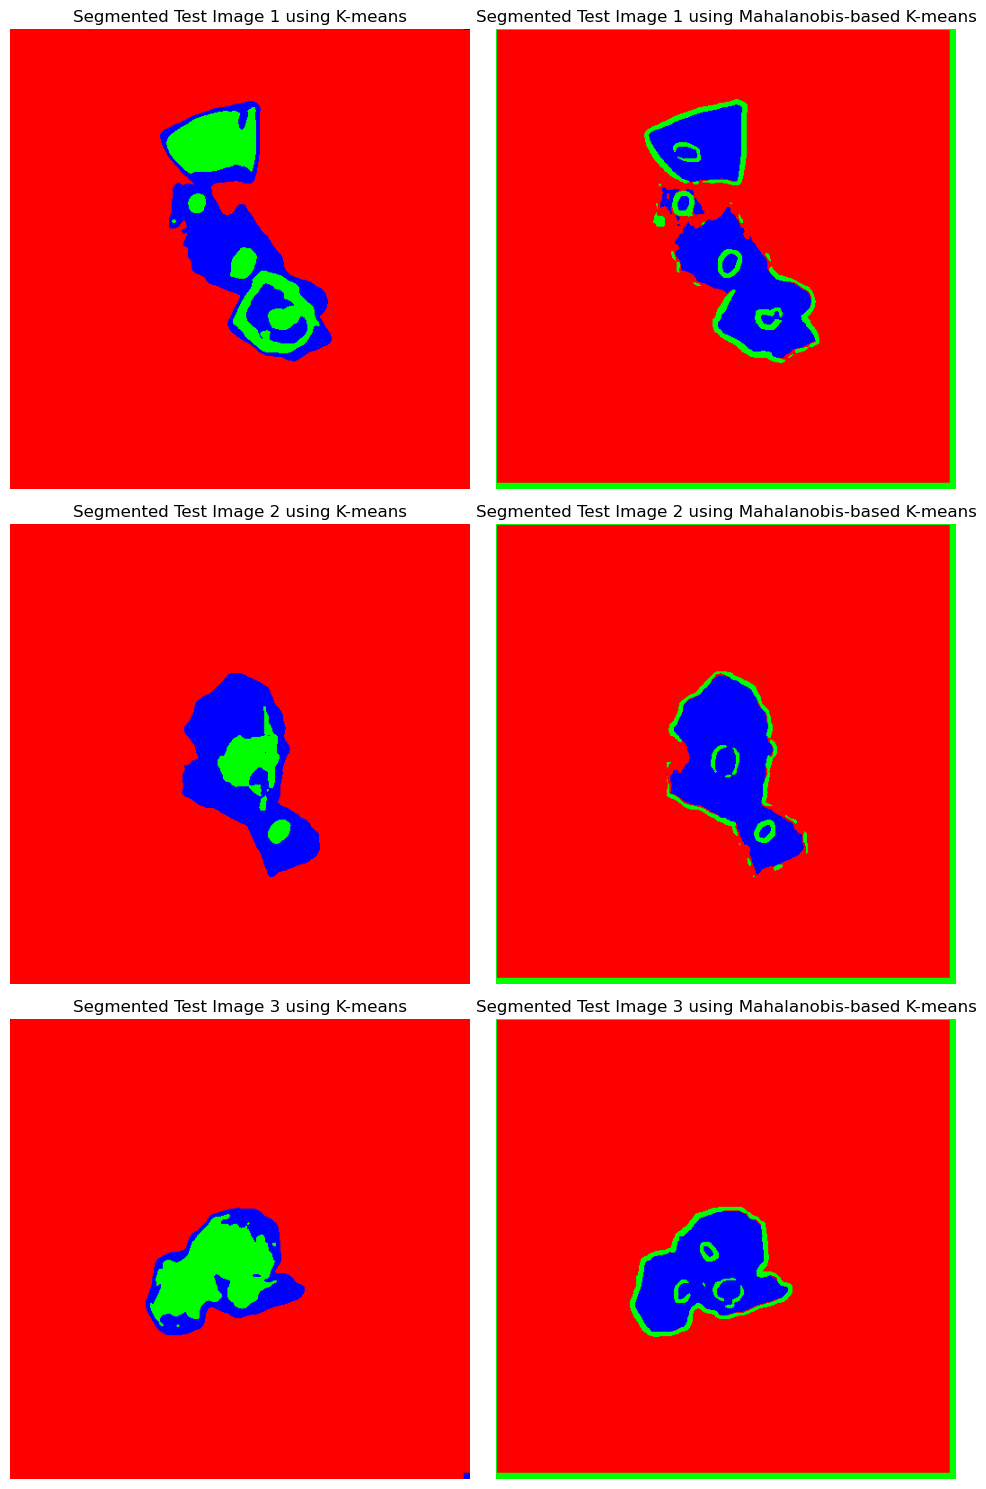

In [16]:

# Function to map cluster labels to colors (background: blue, nucleus: green, other: red)
def map_labels_to_colors(segmented_image):
    # Create an empty RGB image
    color_image = np.zeros((segmented_image.shape[0], segmented_image.shape[1], 3))
    
    # Map label 0 to blue (background)
    color_image[segmented_image == 0] = [0, 1, 0]  # RGB: Blue
    
    # Map label 1 to green (nucleus)
    color_image[segmented_image == 1] = [1, 0, 0]  # RGB: Green
    
    # Map label 2 to red (other parts of the cell)
    color_image[segmented_image == 2] = [0, 0, 1]  # RGB: Red
    
    return color_image

# Function to display images with the mapped colors
def display_segmented_images_with_colors(segmented_images_kmeans, segmented_images_mahalanobis):
    num_images = len(segmented_images_kmeans)
    
    # Create subplots to display K-means and Mahalanobis-based K-means results side by side
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 5))

    # If there's only one image, axes won't be 2D, so handle that case
    if num_images == 1:
        axes = [axes]  # Wrap axes in a list to ensure the loop works

    for i, (kmeans_image, mahalanobis_image) in enumerate(zip(segmented_images_kmeans, segmented_images_mahalanobis)):
        # Map K-means image labels to colors
        kmeans_colored = map_labels_to_colors(kmeans_image)
        mahalanobis_colored = map_labels_to_colors(mahalanobis_image)
        
        # Plot K-means result
        axes[i][0].imshow(kmeans_colored)
        axes[i][0].set_title(f'Segmented Test Image {i+1} using K-means')
        axes[i][0].axis('off')  # Remove axis
        
        # Plot Mahalanobis-based K-means result
        axes[i][1].imshow(mahalanobis_colored)
        axes[i][1].set_title(f'Segmented Test Image {i+1} using Mahalanobis-based K-means')
        axes[i][1].axis('off')  # Remove axis
    
    plt.tight_layout()
    plt.show()

# Example usage: Plot the test images using the function
# Here segmented_images_kmeans_test and segmented_images_mahalanobis_test should contain cluster labels (0, 1, 2)
display_segmented_images_with_colors(segmented_images_kmeans_test, segmented_images_mahalanobis_test)
